Libs

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from itertools import product
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

Load the dataset

In [2]:
df_adj = pd.read_csv('dataset/consensus_adj_mat.csv')
df_adj 

,Unnamed: 0,Akt,Erk,Jnk,Mek,P38,PIP2,PIP3,PKA,PKC,Plcg,Raf
0,Akt,0,0,0,0,0,0,0,0,0,0,0
1,Erk,0,0,0,0,0,0,0,0,0,0,0
2,Jnk,0,0,0,0,0,0,0,0,0,0,0
3,Mek,0,1,0,0,0,0,0,0,0,0,0
4,P38,0,0,0,0,0,0,0,0,0,0,0
5,PIP2,0,0,0,0,0,0,0,0,1,0,0
6,PIP3,1,0,0,0,0,1,0,0,0,1,0
7,PKA,1,1,1,1,1,0,0,0,0,0,1
8,PKC,0,0,1,1,1,0,0,0,0,0,1
9,Plcg,0,0,0,0,0,1,0,0,1,0,0


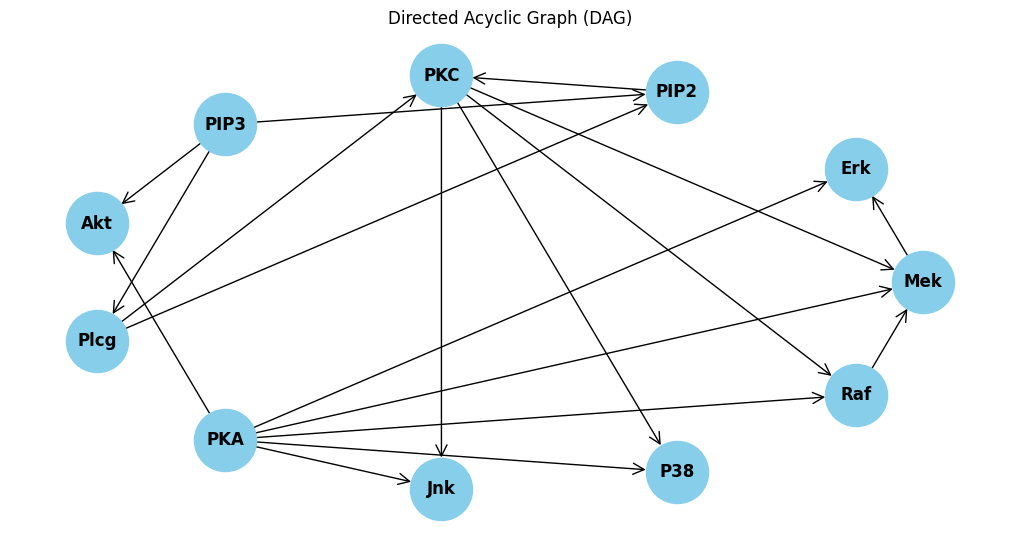

In [3]:
# Initialize a directed graph
G = nx.DiGraph()

# Rename the unnamed column for clarity
df_adj = df_adj.rename(columns={"Unnamed: 0": "Node"})

# Add edges based on the dataframe
for index, row in df_adj.iterrows():
    for col in df_adj.columns[1:]:
        if row[col] == 1:
            G.add_edge(row["Node"], col)

# Use a layout algorithm to position the nodes
pos = nx.circular_layout(G)

# Plot the graph
plt.figure(figsize=(10, 5))
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="skyblue", font_size=12, font_weight="bold", arrowstyle="->", arrowsize=20)
plt.title("Directed Acyclic Graph (DAG)")
plt.show()

In [4]:
print("Nodes: ", G.nodes)
print("Edges: ", G.edges)

Nodes:  ['Mek', 'Erk', 'PIP2', 'PKC', 'PIP3', 'Akt', 'Plcg', 'PKA', 'Jnk', 'P38', 'Raf']
Edges:  [('Mek', 'Erk'), ('PIP2', 'PKC'), ('PKC', 'Jnk'), ('PKC', 'Mek'), ('PKC', 'P38'), ('PKC', 'Raf'), ('PIP3', 'Akt'), ('PIP3', 'PIP2'), ('PIP3', 'Plcg'), ('Plcg', 'PIP2'), ('Plcg', 'PKC'), ('PKA', 'Akt'), ('PKA', 'Erk'), ('PKA', 'Jnk'), ('PKA', 'Mek'), ('PKA', 'P38'), ('PKA', 'Raf'), ('Raf', 'Mek')]


sachs_bin

In [5]:
df_bin = pd.read_csv('dataset/sachs_bin.csv')
df_bin = df_bin.astype(int)
df_bin

,Akt,Erk,Jnk,Mek,P38,PIP2,PIP3,PKA,PKC
0,0,0,1,0,1,0,1,0,1
1,0,0,1,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0
4,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
848,0,0,0,0,0,0,0,0,1
849,0,0,1,0,1,0,1,0,0
850,0,0,0,1,0,0,1,0,0
851,0,0,0,0,1,0,1,0,1


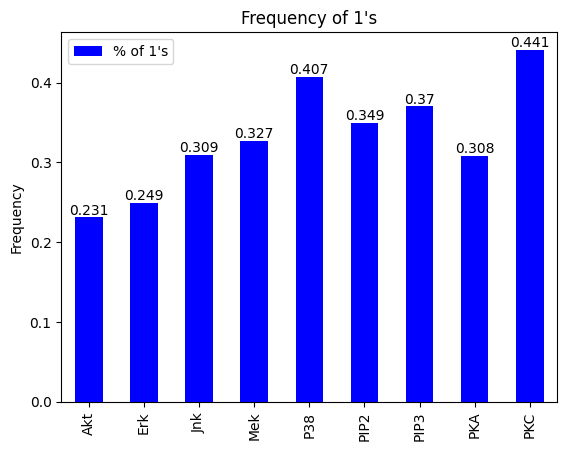

In [6]:
# Calculate the frequency of 1's and 0's for each column
# freq_1 = df_bin.apply(lambda x: x.value_counts().get(1, 0))
freq_1 = np.round(df_bin.mean(), 3)

# Plot the frequency for all rows
fig, ax = plt.subplots()
freq_1.plot(kind='bar', ax=ax, label="% of 1's", color='blue')

for bars in ax.containers:
    ax.bar_label(bars)

plt.ylabel('Frequency')
plt.title('Frequency of 1\'s')
plt.legend()
plt.show()

Forward simulation

In [7]:
alpha = 0.5
nodes = [7, 8, 1, 10, 6, 9, 3, 5, 11, 4, 2]
parents_top = [[], [], [7, 8], [7], [7,10], [10,6], [9,8], [9,8], [9,8], [11, 8, 9], [4, 8]]

# Switch the from topological order to index order
def node_to_index(nodes, parents):
    reordered_parents = [-1] * (max(nodes) + 1)
    for node, parent in zip(nodes, parents):
        reordered_parents[node] = parent
    return reordered_parents[1:max(nodes)+1]
parents = node_to_index(nodes, parents_top)
parents.insert(0, -1)

print(nodes)
print(parents)

[7, 8, 1, 10, 6, 9, 3, 5, 11, 4, 2]
[-1, [7, 8], [4, 8], [9, 8], [11, 8, 9], [9, 8], [7, 10], [], [], [10, 6], [7], [9, 8]]


In [8]:
# def simulate_binomial(alpha):
#     X7, X8 = np.random.binomial(n=1, p=alpha), np.random.binomial(n=1, p=alpha)
    
#     p_X1 = 1 - alpha ** (1+X7+X8) 
#     X1 = np.random.binomial(n=1, p=p_X1)

#     p_X10 = 1 - alpha ** (1+X7)
#     X10 = np.random.binomial(n=1, p=p_X10)

#     p_X6 = 1 - alpha ** (1+X7+X10)
#     X6 = np.random.binomial(n=1, p=p_X6)

#     p_X9 = 1 - alpha ** (1+X10+X6)
#     X9 = np.random.binomial(n=1, p=p_X9)

#     p_X3 = 1 - alpha ** (1+X9+X8)
#     X3 = np.random.binomial(n=1, p=p_X3)

#     p_X5 = 1 - alpha ** (1+X9+X8)
#     X5 = np.random.binomial(n=1, p=p_X5)

#     p_X11 = 1 - alpha ** (1+X9+X8)
#     X11 = np.random.binomial(n=1, p=p_X11)

#     p_X4 = 1 - alpha ** (1+X11+X8+X9)
#     X4 = np.random.binomial(n=1, p=p_X4)

#     p_X2 = 1 - alpha ** (1+X4+X8)
#     X2 = np.random.binomial(n=1, p=p_X2)

#     return [X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11]

# x_list = []
# for i in range(1, 11):
#     x_list.append(f'X{i}')
# simulate_binomial(0.5)

In [9]:
def synthetic_cpd(alpha, parent):
    # Create all possible combinations of parent values
    df = pd.DataFrame(list(product([0, 1], repeat=len(parent))), columns=parent)
    df['prob'] = 1 - alpha ** (1 + df.sum(axis=1)) # P(X=1|parents)
    return df

df_x7 = synthetic_cpd(alpha, parents[7])
df_x8 = synthetic_cpd(alpha, parents[8])
df_x1 = synthetic_cpd(alpha, parents[1])
df_x10 = synthetic_cpd(alpha, parents[10])
df_x6 = synthetic_cpd(alpha, parents[6])
df_x9 = synthetic_cpd(alpha, parents[9])
df_x3 = synthetic_cpd(alpha, parents[3])
df_x5 = synthetic_cpd(alpha, parents[5])
df_x11 = synthetic_cpd(alpha, parents[11])
df_x4 = synthetic_cpd(alpha, parents[4])
df_x2 = synthetic_cpd(alpha, parents[2])

print(df_x1[(df_x1[7] == 1) & (df_x1[8] == 1)]['prob'].values)

[0.875]


In [10]:
# condition = (df_x1[8] == 1).values
# print(condition)
def get_parrents(df : pd.DataFrame) -> list:
    return [col for col in df.columns if not str(col).startswith('prob')]

# df -> The conditional probability table
# state -> The state of the parents true/false
# returns -> The probability of the state
    # It's important that the state is given in the same order  as the columns of the dataframe.
def return_probability(df : pd.DataFrame, state : list) -> int:
    #Index of all columns that are not the probability
    parents = [col for col in df.columns if not str(col).startswith('prob')]
    # print(parents)
    # Table where the row 
    condition = (df[parents] == state).all(axis=1)
    # Get the probability of the condition
    matching_probabilities = df.loc[condition, 'prob'] # returns the row where the condition is true
    matching_probabilities = matching_probabilities.values # single value list

    return matching_probabilities[0]

print(return_probability(df_x1, [0,0]))

0.5


Simulation

In [11]:
def simulate_binomial(nodes, print_outcomes = False):
    # Simulate
    X7, X8 = np.random.binomial(n=1, p=df_x7['prob']), np.random.binomial(n=1, p=df_x8['prob'])
    X7, X8 = X7[0], X8[0] # We want the value as an integer, not a list

    p_x1 = return_probability(df_x1, [X7, X8])
    X1 = np.random.binomial(n=1, p=p_x1)

    p_x10 = return_probability(df_x10, [X7])
    X10 = np.random.binomial(n=1, p=p_x10)

    p_x6 = return_probability(df_x6, [X7, X10])
    X6 = np.random.binomial(n=1, p=p_x6)

    p_x9 = return_probability(df_x9, [X10, X6])
    X9 = np.random.binomial(n=1, p=p_x9)

    p_x3 = return_probability(df_x3, [X9, X8])
    X3 = np.random.binomial(n=1, p=p_x3)

    p_x5 = return_probability(df_x5, [X9, X8])
    X5 = np.random.binomial(n=1, p=p_x5)

    p_x11 = return_probability(df_x11, [X9, X8])
    X11 = np.random.binomial(n=1, p=p_x11)

    p_x4 = return_probability(df_x4, [X11, X8, X9])
    X4 = np.random.binomial(n=1, p=p_x4)

    p_x2 = return_probability(df_x2, [X4, X8])
    X2 = np.random.binomial(n=1, p=p_x2)

    if print_outcomes:
        print('Simulating')
        print('(X1, p) = ', ((X1, p_x1)), 'pa = ', get_parrents(df_x1))
        print('(X2, p) = ', ((X2, p_x2)), 'pa = ', get_parrents(df_x2))
        print('(X3, p) = ', ((X3, p_x3)), 'pa = ', get_parrents(df_x3))
        print('(X4, p) = ', ((X4, p_x4)), 'pa = ', get_parrents(df_x4))
        print('(X5, p) = ', ((X5, p_x5)), 'pa = ', get_parrents(df_x5))
        print('(X6, p) = ', ((X6, p_x6)), 'pa = ', get_parrents(df_x6))
        print('(X7, p) = ', ((X7, df_x7['prob'][0])), 'pa = ', get_parrents(df_x7)) 
        print('(X8, p) = ', ((X8, df_x8['prob'][0])), 'pa = ', get_parrents(df_x8))
        print('(X9, p) = ', ((X9, p_x9)), 'pa = ', get_parrents(df_x9))
        print('(X10, p) = ', ((X10, p_x10)), 'pa = ', get_parrents(df_x10))
        print('(X11, p) = ', ((X11, p_x11)), 'pa = ', get_parrents(df_x11))
    return [X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11]


simulate_binomial(nodes, True)

Simulating
(X1, p) =  (1, 0.75) pa =  [7, 8]
(X2, p) =  (0, 0.75) pa =  [4, 8]
(X3, p) =  (1, 0.75) pa =  [9, 8]
(X4, p) =  (1, 0.875) pa =  [11, 8, 9]
(X5, p) =  (1, 0.75) pa =  [9, 8]
(X6, p) =  (1, 0.875) pa =  [7, 10]
(X7, p) =  (1, 0.5) pa =  []
(X8, p) =  (0, 0.5) pa =  []
(X9, p) =  (1, 0.875) pa =  [10, 6]
(X10, p) =  (1, 0.75) pa =  [7]
(X11, p) =  (1, 0.75) pa =  [9, 8]


[1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1]

In [12]:
def forward(alpha, n):
    lst = []
    for elm in range(0, n):
        lst.append(simulate_binomial(alpha))
    df_adj=pd.DataFrame(lst,columns=['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10','X11'])
    return(df_adj)

In [13]:
# # Simulation size
# n = 50000
# # Calculate the frequency of 1's and 0's for each column
# # for_freq_1 = forward(0.5, 1000).apply(lambda x: x.value_counts().get(1, 0))
# for_freq_1 = np.round(forward(0.5, n).mean(), 3) 

# # Plot the frequency for all rows
# fig, ax = plt.subplots()
# for_freq_1.plot(kind='bar', ax=ax, label="% of 1's", color='red', alpha=0.8)

# for bars in ax.containers:
#     ax.bar_label(bars)

# plt.ylabel('Frequency')
# plt.title(f'Frequency of 1\'s for {n} simluations')
# plt.legend()
# plt.show()

In [14]:
# fig, ax = plt.subplots()

# width = 0.35  # width of the bars

# # Plot the freq_1 bars
# ax.bar(np.arange(len(freq_1)), freq_1, width, label='freq_1', color='blue')

# # Plot the for_freq_1 bars next to freq_1 bars
# ax.bar(np.arange(len(for_freq_1)) + width, for_freq_1, width, label='for_freq_1', color='red', alpha=0.5)

# for bars in ax.containers:
#     ax.bar_label(bars)

# ax.set_ylabel('Frequency')
# ax.set_title('Comparison of freq_1 and for_freq_1')
# ax.set_xticks(np.arange(len(for_freq_1)) + width / 2)
# ax.set_xticklabels(for_freq_1.index)
# ax.legend()

# plt.show()

Logistic regression

In [15]:
# Initialize a logistic regression model
log = LogisticRegression(random_state=42, max_iter=1000)
lst_10 = []
lst_11 = []

for i in [100, 1000, 10000, 50000]:
    df_sim_data = forward(0.5, i)
    y_10 = df_sim_data.pop('X10')
    y_11 = df_sim_data.pop('X11')

    # Split the dataframe into train and test sets
    x_train, x_test = train_test_split(df_sim_data, test_size=0.2, random_state=42)
    y_10_train, y_10_test = train_test_split(y_10, test_size=0.2, random_state=42)
    y_11_train, y_11_test = train_test_split(y_11, test_size=0.2, random_state=42)

    log_reg_y_10 = log.fit(x_train, y_10_train)
    pred_log_reg_y_10 = log_reg_y_10.predict(x_test) 
    lst_10.append(log_reg_y_10.score(x_test, y_10_test))
    print(f'{i}: Log_Reg accuracy for X10: {log_reg_y_10.score(x_test, y_10_test)}')

    log_reg_y_11 = log.fit(x_train, y_11_train)
    pred_log_reg_y_11 = log_reg_y_11.predict(x_test) 
    lst_11.append(log_reg_y_11.score(x_test, y_11_test))
    print(f'{i}: Log_Reg accuracy for X11: {log_reg_y_11.score(x_test, y_11_test)}')
    print("\n")
    
print(lst_10)
print(lst_11)

100: Log_Reg accuracy for X10: 0.9
100: Log_Reg accuracy for X11: 0.9


1000: Log_Reg accuracy for X10: 0.705
1000: Log_Reg accuracy for X11: 0.74


10000: Log_Reg accuracy for X10: 0.6865
10000: Log_Reg accuracy for X11: 0.771


50000: Log_Reg accuracy for X10: 0.7003
50000: Log_Reg accuracy for X11: 0.791


[0.9, 0.705, 0.6865, 0.7003]
[0.9, 0.74, 0.771, 0.791]


Plot

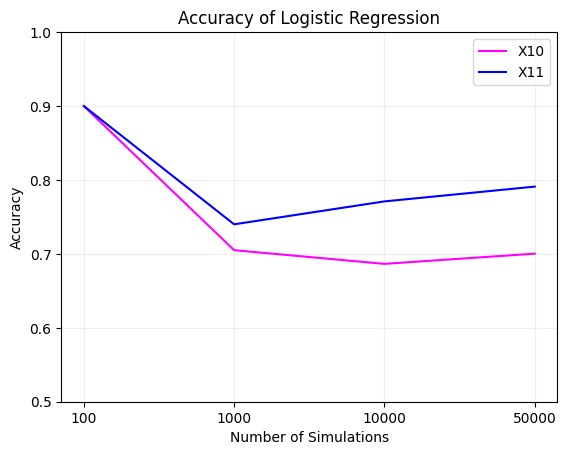

In [18]:
plt.plot(['100', '1000', '10000', '50000'], lst_10, label='X10', color='magenta')
plt.plot(['100', '1000', '10000', '50000'], lst_11, label='X11', color='blue')
plt.xlabel('Number of Simulations')
plt.ylabel('Accuracy')
plt.ylim(0.5, 1)
plt.title('Accuracy of Logistic Regression')
plt.grid(alpha=0.2)
plt.legend()
plt.show()